In [12]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [13]:
%%cython
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas
from tensorflow.keras.models import Sequential
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers
from keras.callbacks import EarlyStopping
from keras.layers.normalization import BatchNormalization
csv = './openpowerlifting-2020-09-06.csv'
df = pandas.read_csv(csv,index_col=0,low_memory=False)
df['Sex'] = df['Sex'].map({'M': 1, 'F': 0, 'Mx': -1})
df['Equipment'] = df['Equipment'].map({'Single-ply':0, 'Raw':1, 'Wraps':2, 'Unlimited':3, 'Multi-ply':4})
data = df[['Sex','BodyweightKg', 'Best3SquatKg', 'Best3DeadliftKg','Age','Equipment', 'Best3BenchKg']].dropna(how='any')

In [4]:
data.count()

Sex                681124
BodyweightKg       681124
Best3SquatKg       681124
Best3DeadliftKg    681124
Age                681124
Equipment          681124
Best3BenchKg       681124
dtype: int64

In [5]:
data.head(5)

,Sex,BodyweightKg,Best3SquatKg,Best3DeadliftKg,Age,Equipment,Best3BenchKg
Name,,,,,,,
Clint Samuels,1,82.5,195.04,249.48,27.5,2.0,138.35
Zach Lerner,1,82.5,183.70,215.46,32.5,2.0,111.13
Sam Cox #2,1,110.0,288.03,317.51,24.0,2.0,163.29
Adam Vediz,1,110.0,226.80,226.80,38.5,2.0,170.10
Michaela Smith,0,75.0,138.35,142.88,27.0,2.0,65.77


In [14]:
# 相関係数の総当たり
data.corr().style.background_gradient(cmap="autumn_r")

,Sex,BodyweightKg,Best3SquatKg,Best3DeadliftKg,Age,Equipment,Best3BenchKg
Sex,1.000000,0.457761,0.582588,0.652562,0.011873,0.030664,0.644853
BodyweightKg,0.457761,1.000000,0.630325,0.625848,0.149357,0.138988,0.651897
Best3SquatKg,0.582588,0.630325,1.000000,0.873304,0.022368,0.060259,0.889040
Best3DeadliftKg,0.652562,0.625848,0.873304,1.000000,0.049764,0.061474,0.840447
Age,0.011873,0.149357,0.022368,0.049764,1.000000,0.114414,0.083975
Equipment,0.030664,0.138988,0.060259,0.061474,0.114414,1.000000,0.067958
Best3BenchKg,0.644853,0.651897,0.889040,0.840447,0.083975,0.067958,1.000000


In [4]:
data = np.array(data)
data.shape

(681124, 7)

In [5]:
# MinMaxScalerで正規化を実施
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
data_std = sc.fit_transform(data)
data_std.shape

(681124, 7)

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(data_std[:,:-1], data_std[:,-1], test_size=0.2)

In [7]:
# Trainをさらに 8:2 に分ける
X_train, X_validation, Y_train, Y_validation = train_test_split(X_train, Y_train, test_size=0.2)

In [19]:
print("学習データ：", Y_train.shape, X_train.shape)
print("検証データ：", Y_validation.shape, X_validation.shape)
print("Testデータ：", Y_test.shape, X_test.shape)

学習データ： (435919,) (435919, 6)
検証データ： (108980,) (108980, 6)
Testデータ： (136225,) (136225, 6)


In [32]:
from tensorflow.keras.models import Sequential
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers
from keras.callbacks import EarlyStopping
from keras.layers.normalization import BatchNormalization

# coefficient of determination (R^2) for regression
def r_square(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return (1 - SS_res/(SS_tot + K.epsilon()))

# 特徴量の数=入力層の列数(ニューロン数)=18
n_features = 6
# 隠れ層のニューロン数
n_hidden   = 4

# モデルの初期化
model = Sequential()

# 入力層
model.add(Dense(n_hidden, activation='sigmoid', input_shape=(n_features,)))
# 隠れ層
model.add(Dense(n_hidden, activation='sigmoid'))
# 出力層
model.add(Dense(1, activation='sigmoid'))

# モデルの構築
optimizer = optimizers.SGD(learning_rate=0.1)
model.compile(optimizer=optimizer,
              loss='mse', metrics=['mae', r_square])

In [35]:
log = model.fit(X_train, Y_train, epochs=30, batch_size=64, verbose=1,
         validation_data=(X_validation, Y_validation))
Y_pred = model.predict(X_test)

Epoch 1/30
6812/6812 [==============================] - 11s 2ms/step - loss: 0.0026 - mae: 0.0395 - r_square: 0.3543 - val_loss: 0.0024 - val_mae: 0.0375 - val_r_square: 0.4048
Epoch 2/30
6812/6812 [==============================] - 10s 2ms/step - loss: 0.0023 - mae: 0.0360 - r_square: 0.4390 - val_loss: 0.0021 - val_mae: 0.0346 - val_r_square: 0.4720
Epoch 3/30
6812/6812 [==============================] - 9s 1ms/step - loss: 0.0020 - mae: 0.0337 - r_square: 0.4924 - val_loss: 0.0019 - val_mae: 0.0327 - val_r_square: 0.5152
Epoch 4/30
6812/6812 [==============================] - 9s 1ms/step - loss: 0.0019 - mae: 0.0321 - r_square: 0.5314 - val_loss: 0.0018 - val_mae: 0.0312 - val_r_square: 0.5512
Epoch 5/30
6812/6812 [==============================] - 8s 1ms/step - loss: 0.0018 - mae: 0.0307 - r_square: 0.5666 - val_loss: 0.0017 - val_mae: 0.0299 - val_r_square: 0.5871
Epoch 6/30
6812/6812 [==============================] - 8s 1ms/step - loss: 0.0016 - mae: 0.0293 - r_square: 0.6034 - 

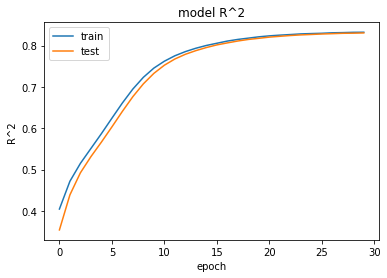

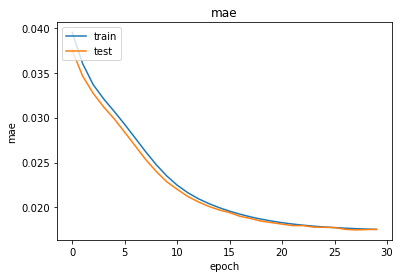

In [36]:
# plot training curve for R^2 (beware of scale, starts very low negative)
plt.plot(log.history['val_r_square'])
plt.plot(log.history['r_square'])
plt.title('model R^2')
plt.ylabel('R^2')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# plot training curve for rmse
plt.plot(log.history['mae'])
plt.plot(log.history['val_mae'])
plt.title('mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [19]:
from tensorflow.keras.models import Sequential
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import optimizers
from keras.callbacks import EarlyStopping
from keras.layers.normalization import BatchNormalization

# coefficient of determination (R^2) for regression
def r_square(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return (1 - SS_res/(SS_tot + K.epsilon()))

# 特徴量の数=入力層の列数(ニューロン数)=18
n_features = 6
# 隠れ層のニューロン数
n_hidden   = 4

# モデルの初期化
model = Sequential()

# 入力層
model.add(Dense(n_hidden, activation='tanh', input_shape=(n_features,)))
# ドロップアウト
model.add(Dropout(0.5))
# 隠れ層
model.add(Dense(n_hidden, activation='tanh'))
# ドロップアウト
model.add(Dropout(0.5))
# 隠れ層
model.add(Dense(n_hidden, activation='tanh'))
# ドロップアウト
model.add(Dropout(0.5))
# 隠れ層
model.add(Dense(n_hidden, activation='tanh'))
# ドロップアウト
model.add(Dropout(0.5))
# 隠れ層
model.add(Dense(n_hidden, activation='tanh'))
# ドロップアウト
model.add(Dropout(0.5))
# 出力層
model.add(Dense(1, activation='tanh'))

# モデルの構築
optimizer = optimizers.SGD(learning_rate=0.1)
model.compile(optimizer=optimizer,
              loss='mse', metrics=['mae', r_square])

In [20]:
log = model.fit(X_train, Y_train, epochs=100, batch_size=64, verbose=1,
         validation_data=(X_validation, Y_validation))
Y_pred = model.predict(X_test)

Epoch 1/100
6812/6812 [==============================] - 11s 2ms/step - loss: 0.0131 - mae: 0.0694 - r_square: -2.4432 - val_loss: 0.0039 - val_mae: 0.0503 - val_r_square: 0.0285
Epoch 2/100
6812/6812 [==============================] - 10s 1ms/step - loss: 0.0039 - mae: 0.0504 - r_square: 0.0135 - val_loss: 0.0035 - val_mae: 0.0473 - val_r_square: 0.1379
Epoch 3/100
6812/6812 [==============================] - 10s 1ms/step - loss: 0.0037 - mae: 0.0486 - r_square: 0.0662 - val_loss: 0.0030 - val_mae: 0.0435 - val_r_square: 0.2548
Epoch 4/100
6812/6812 [==============================] - 10s 1ms/step - loss: 0.0035 - mae: 0.0469 - r_square: 0.1176 - val_loss: 0.0027 - val_mae: 0.0405 - val_r_square: 0.3405
Epoch 5/100
6812/6812 [==============================] - 10s 2ms/step - loss: 0.0034 - mae: 0.0456 - r_square: 0.1585 - val_loss: 0.0024 - val_mae: 0.0379 - val_r_square: 0.4112
Epoch 6/100
6812/6812 [==============================] - 11s 2ms/step - loss: 0.0032 - mae: 0.0444 - r_square

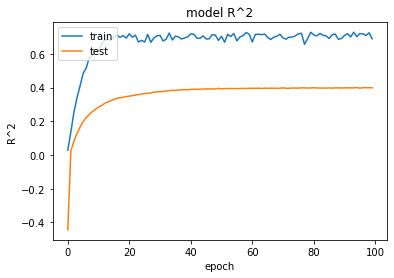

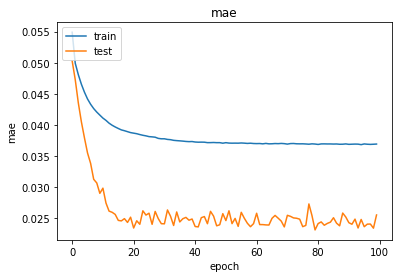

In [21]:
# plot training curve for R^2 (beware of scale, starts very low negative)
plt.plot(log.history['val_r_square'])
plt.plot(log.history['r_square'])
plt.title('model R^2')
plt.ylabel('R^2')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# plot training curve for rmse
plt.plot(log.history['mae'])
plt.plot(log.history['val_mae'])
plt.title('mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [22]:
from tensorflow.keras.models import Sequential
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers
from keras.callbacks import EarlyStopping
from keras.layers.normalization import BatchNormalization

# coefficient of determination (R^2) for regression
def r_square(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return (1 - SS_res/(SS_tot + K.epsilon()))

# 特徴量の数=入力層の列数(ニューロン数)=18
n_features = 6
# 隠れ層のニューロン数
n_hidden   = 4

# モデルの初期化
model = Sequential()

# 入力層
model.add(Dense(n_hidden, activation='sigmoid', input_shape=(n_features,)))
# 隠れ層
model.add(Dense(n_hidden, activation='sigmoid'))
# 出力層
model.add(Dense(1, activation='sigmoid'))

# モデルの構築
optimizer = optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=optimizer,
              loss='mse', metrics=['mae', r_square])

In [23]:
log = model.fit(X_train, Y_train, epochs=30, batch_size=64, verbose=1,
         validation_data=(X_validation, Y_validation))
Y_pred = model.predict(X_test)

Epoch 1/30
6812/6812 [==============================] - 12s 2ms/step - loss: 0.0028 - mae: 0.0324 - r_square: 0.3011 - val_loss: 6.6228e-04 - val_mae: 0.0172 - val_r_square: 0.8383
Epoch 2/30
6812/6812 [==============================] - 12s 2ms/step - loss: 6.8823e-04 - mae: 0.0176 - r_square: 0.8321 - val_loss: 6.5462e-04 - val_mae: 0.0171 - val_r_square: 0.8401
Epoch 3/30
6812/6812 [==============================] - 11s 2ms/step - loss: 6.5662e-04 - mae: 0.0174 - r_square: 0.8381 - val_loss: 6.6240e-04 - val_mae: 0.0179 - val_r_square: 0.8380
Epoch 4/30
6812/6812 [==============================] - 11s 2ms/step - loss: 6.6351e-04 - mae: 0.0174 - r_square: 0.8378 - val_loss: 6.4774e-04 - val_mae: 0.0170 - val_r_square: 0.8418
Epoch 5/30
6812/6812 [==============================] - 13s 2ms/step - loss: 6.6035e-04 - mae: 0.0173 - r_square: 0.8385 - val_loss: 6.5029e-04 - val_mae: 0.0175 - val_r_square: 0.8408
Epoch 6/30
6812/6812 [==============================] - 12s 2ms/step - loss: 6.

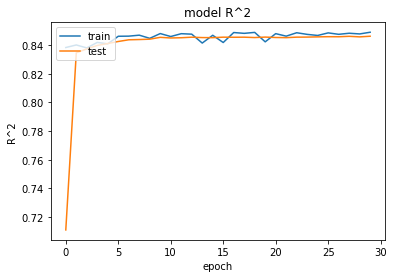

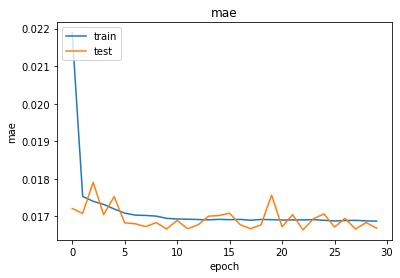

In [25]:
# plot training curve for R^2 (beware of scale, starts very low negative)
plt.plot(log.history['val_r_square'])
plt.plot(log.history['r_square'])
plt.title('model R^2')
plt.ylabel('R^2')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# plot training curve for rmse
plt.plot(log.history['mae'])
plt.plot(log.history['val_mae'])
plt.title('mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
from tensorflow.keras.models import Sequential
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers
from keras.callbacks import EarlyStopping
from keras.layers.normalization import BatchNormalization

# coefficient of determination (R^2) for regression
def r_square(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return (1 - SS_res/(SS_tot + K.epsilon()))

# 特徴量の数=入力層の列数(ニューロン数)=18
n_features = 6
# 隠れ層のニューロン数
n_hidden   = 4

# モデルの初期化
model = Sequential()

# 入力層
model.add(Dense(n_hidden, activation='tanh', input_shape=(n_features,)))
# 隠れ層
model.add(Dense(n_hidden, activation='tanh'))
# 出力層
model.add(Dense(1, activation='tanh'))

# モデルの構築
optimizer = optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=optimizer,
              loss='mse', metrics=['mae', r_square])
log = model.fit(X_train, Y_train, epochs=30, batch_size=64, verbose=1,
         validation_data=(X_validation, Y_validation))
Y_pred = model.predict(X_test)

Epoch 1/30
6812/6812 [==============================] - 11s 2ms/step - loss: 0.0019 - mae: 0.0261 - r_square: 0.5187 - val_loss: 0.0010 - val_mae: 0.0240 - val_r_square: 0.7421
Epoch 2/30
6812/6812 [==============================] - 11s 2ms/step - loss: 7.1004e-04 - mae: 0.0183 - r_square: 0.8266 - val_loss: 6.5508e-04 - val_mae: 0.0175 - val_r_square: 0.8399
Epoch 3/30
6812/6812 [==============================] - 11s 2ms/step - loss: 6.7719e-04 - mae: 0.0179 - r_square: 0.8343 - val_loss: 7.1735e-04 - val_mae: 0.0192 - val_r_square: 0.8240
Epoch 4/30
6812/6812 [==============================] - 12s 2ms/step - loss: 6.8129e-04 - mae: 0.0177 - r_square: 0.8343 - val_loss: 8.0896e-04 - val_mae: 0.0204 - val_r_square: 0.8006
Epoch 5/30
6812/6812 [==============================] - 12s 2ms/step - loss: 6.6873e-04 - mae: 0.0178 - r_square: 0.8359 - val_loss: 6.2882e-04 - val_mae: 0.0167 - val_r_square: 0.8473
Epoch 6/30
6812/6812 [==============================] - 14s 2ms/step - loss: 6.6181